In [1]:
%load_ext autoreload
%autoreload 2

import jCMIP as jc
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import copy

In [2]:
# Compute distance between two points:
def comp_dist(lon1,lat1,lon2,lat2):
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)
    dlat = lat2-lat1
    dlon = lon2-lon1
    R = 6371e3 # Radius of Earth
    a = (np.sin(dlat/2))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin(dlon/2))**2
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R*c
    
    return d

# Tidying up the boundary longitudes:
def test_lon(lon1,lon2):
    dlon = lon2-lon1
    newlon2 = copy.deepcopy(lon2)
    newlon2[np.where(dlon > 180)] = lon2[np.where(dlon > 180)] - 360 
    newlon2[np.where(dlon < -180)] = lon2[np.where(dlon < -180)] + 360 
    
    return newlon2

# Compute dz on t-points:
def compdz(Model,dxt,dyt,Tfile):
    dzt = []

    # Check for time invarient cell thickness and/or volume:
    if Model.cmip == '5':
        vtype = 'fx'
    elif Model.cmip == '6':
        vtype = 'Ofx'
    thkFiles = Model.getFiles(var='thkcello', EXP='*',ENS='*',vtype=vtype,gtype='gn')
    volFiles = Model.getFiles(var='volcello', EXP='*',ENS='*',vtype=vtype,gtype='gn')
    areFiles = Model.getFiles(var='areacello',EXP='*',ENS='*',vtype=vtype,gtype='gn')

    print(thkFiles)
    print(volFiles)
    print(areFiles)
    
    if (len(thkFiles) != 0):
        dzt = jc.Oread3Ddata(Model,thkFiles[0],var='thkcello')[:,:,:]
    elif (len(volFiles) != 0):
        vol = jc.Oread3Ddata(Model,volFiles[0],var='volcello')[:,:,:]
        if(len(areFiles) != 0):
            area = jc.Oread2Ddata(Model,areFiles[0],var='areacello')[:,:]
        else:
            area = dxt*dyt
        dzt = vol/np.tile(area,(np.size(vol,axis=0),1,1))
    else:
        ncid = Dataset(so,'r')
        dims = ncid.variables['so'].get_dims()
        bounds = ncid.variables[dims[1].name].bounds
        dz_b = ncid.variables[bounds][:,:]
        dz = dz_b[:,1] - dz_b[:,0]
        dzt = np.swapaxes(np.tile(dz,(dims[3].size-np.sum(Model.OextraWE),dims[2].size,1)),0,2)
        ncid.close()
        
    dzt[np.isnan(dzt)] = 0
    
    #if (Model.name == 'MRI-CGCM3'):
    #    dzt[-1,:,:] = 0
        
    return dzt

In [40]:
#cmip   = '5'
cmip   = '6'
Clist = jc.readList(('../CMIP' + cmip + 'list'))
Models = list(Clist.keys())

Model = Clist[Models[60]]
print(Model.name)
print(Model.Olon)
print(Model.Olat)
print(Model.Ogrid)
print(Model.Omeshmask)

# Not enough info/atmos only - 6/2, 6/3, 6/27, 6/28, 6/29, 6/38, 6/42, 6/46, 6/48, 6/59, 6/62, 6/63, 6/65, 6/66, 6/67, 6/69, 6/72, 6/73
# 6/75, 6/82, 6/83, 6/86, 6/87, 6/88, 5/95
# Unstructured grid - 6/4, 6/5
# Retry on high memory machine - 6/60 (HadGEM3-GC31-MH)
# Problem with mask, only coastline? - 6/11 (CESM1-CAM5-SE-HR) 
# No uo/vo files - 6/26 (CanESM5-CanOE), 6/33 (EC-Earth3-LR), 6/50 (GFDL-ESM4), 6/51 (GFDL-OM4p5B), 6/54 (GISS-E2-1-H), 6/55 (GISS-E2-2-G)
# 6/64 (IITM-ESM), 6/89 (NorCPM1), 6/90 (NorESM1-F)

HadGEM3-GC31-MH
longitude
latitude
Ctr
unknown


In [41]:
# Get longitudes, latitudes and masks:

# Find Files:
so = Model.getFiles(var='so',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]
vo = Model.getFiles(var='vo',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]
uo = Model.getFiles(var='uo',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]

Tlon,Tlat = jc.Olatlon(Model,so,'so')

# lat/lon not given on U/V points:
if ((Model.name == 'CAS-ESM2-0')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = ncid.variables['lon_bnds'][:,0]
    Ulat = ncid.variables['lat_bnds'][:,0]
    ncid.close()

    Vlon = Ulon
    Vlat = Ulat
    
    Tlon,Tlat = np.meshgrid(Tlon,Tlat)
    Ulon,Ulat = np.meshgrid(Ulon,Ulat)
    Vlon,Vlat = np.meshgrid(Vlon,Vlat)   
elif ((Model.name == 'CIESM')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = ncid.variables['vertices_longitude'][:,:,0]
    Ulat = ncid.variables['vertices_latitude'][:,:,0]
    ncid.close()

    Vlon = Ulon
    Vlat = Ulat
elif ((Model.name == 'GFDL-CM4')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = (ncid.variables['lon_bnds'][:,:,1] + ncid.variables['lon_bnds'][:,:,2])/2
    Ulat = (ncid.variables['lat_bnds'][:,:,1] + ncid.variables['lat_bnds'][:,:,2])/2
    Vlon = (ncid.variables['lon_bnds'][:,:,3] + ncid.variables['lon_bnds'][:,:,2])/2
    Vlat = (ncid.variables['lat_bnds'][:,:,3] + ncid.variables['lat_bnds'][:,:,2])/2
    ncid.close()
else:
    # Read in lon and lat:
    Ulon,Ulat = jc.Olatlon(Model,uo,'uo')
    Vlon,Vlat = jc.Olatlon(Model,vo,'vo')
    if Model.Oreg:
        Tlon,Tlat = np.meshgrid(Tlon,Tlat)
        Ulon,Ulat = np.meshgrid(Ulon,Ulat)
        Vlon,Vlat = np.meshgrid(Vlon,Vlat)

# Read in mask:
if ((Model.name == 'MRI-ESM2-0')):
    # data is stored as NaNs:
    Tmask     = 1 - np.isnan(jc.Oread3Ddata(Model,so,var='so',time=0))
    Umask     = 1 - np.isnan(jc.Oread3Ddata(Model,uo,var='uo',time=0))
    Vmask     = 1 - np.isnan(jc.Oread3Ddata(Model,vo,var='vo',time=0))
else:
    Tmask     = jc.Oread3Ddata(Model,so,var='so',time=0,mask=True)
    Umask     = jc.Oread3Ddata(Model,uo,var='uo',time=0,mask=True)
    Vmask     = jc.Oread3Ddata(Model,vo,var='vo',time=0,mask=True)

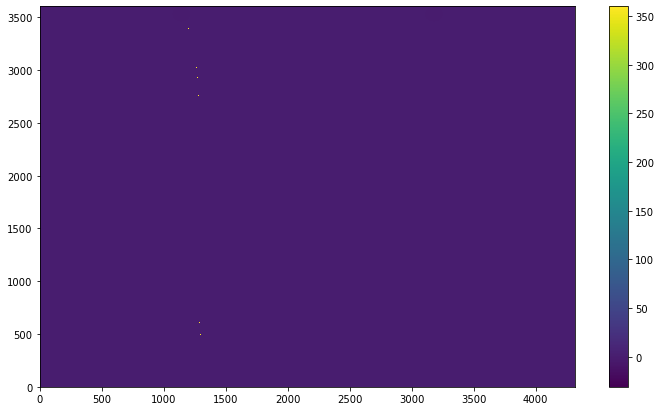

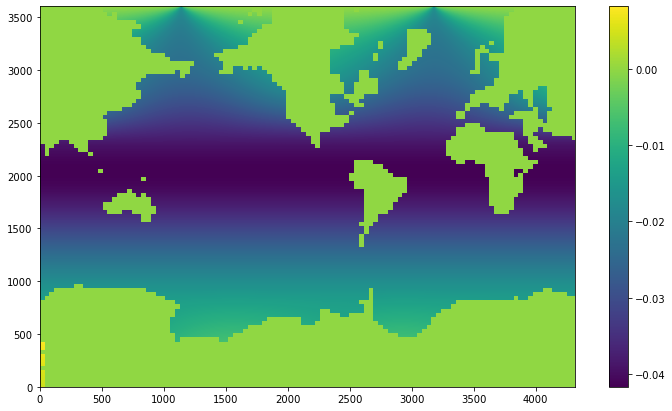

In [42]:
# Check if lon/lat on U and V points is properly given:

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Tlon-Ulon)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Tlat-Vlat)
plt.colorbar()

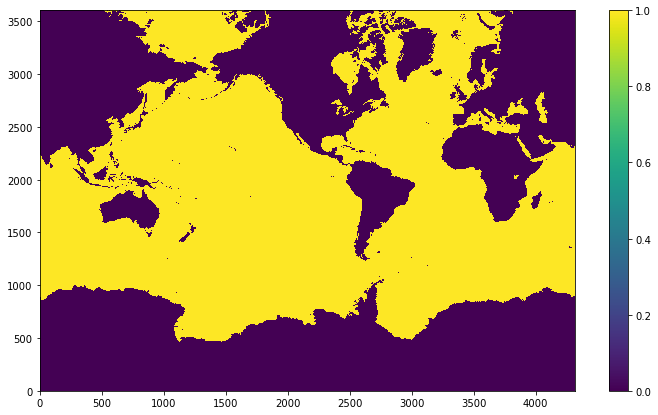

In [43]:
fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Tmask[0,:,:])
plt.colorbar()

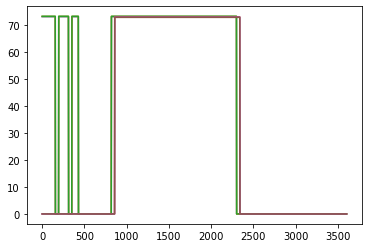

In [44]:
plt.plot(Tlon[:,0])
plt.plot(Tlon[:,1])
plt.plot(Tlon[:,2])
plt.plot(Tlon[:,-1])
plt.plot(Tlon[:,-2])
plt.plot(Tlon[:,-3])
#plt.xlim([0,100])
#plt.ylim([-0.2,0.2])
#plt.ylim([50,70])

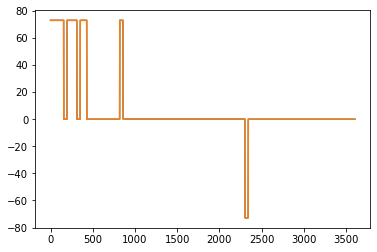

In [45]:
plt.plot(Tlon[:,0]-Tlon[:,-2])
plt.plot(Tlon[:,1]-Tlon[:,-1])

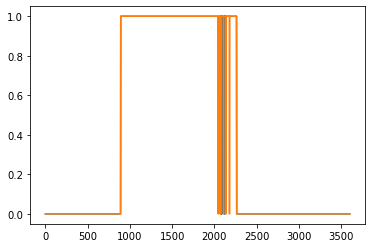

In [46]:
plt.plot(Tmask[0,:,-1])
plt.plot(Tmask[0,:,0])

In [47]:
print(np.shape(Tmask))

(75, 3604, 4320)


In [48]:
print(np.shape(Tmask))
print(np.shape(Umask))
print(np.shape(Vmask))

(75, 3604, 4320)
(75, 3604, 4320)
(75, 3604, 4320)


In [49]:
# Compute grid information for Btr model grid:
if Model.Ogrid == 'Btr':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top right
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so[0])*Tmask
  
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top right
    lon3 = copy.deepcopy(Vlon) # top left
    lon3 = np.roll(lon3,-1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2[:-1,:] = lon4[1:,:]
    lon1 = copy.deepcopy(lon3) # bottom left
    lon1[:-1,:] = lon3[1:,:]
    
    lat4 = copy.deepcopy(Vlat) # top right
    lat3 = copy.deepcopy(Vlat) # top left
    lat3 = np.roll(lat3,-1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2[:-1,:] = lat4[1:,:]
    lat1 = copy.deepcopy(lat3) # bottom left
    lat1[:-1,:] = lat3[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,:-1,:] = dzt[:,1:,:]
    dzu3 = np.roll(dzu3,-1,axis=2)
    dzu4[:,:-1,:] = dzu3[:,1:,:]

    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [50]:
# Compute grid information for Btr model grid:
if Model.Ogrid == 'Btl':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top right
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so[0])*Tmask
  
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top right
    lon3 = copy.deepcopy(Vlon) # top left
    lon3 = np.roll(lon3,1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2[:-1,:] = lon4[1:,:]
    lon1 = copy.deepcopy(lon3) # bottom left
    lon1[:-1,:] = lon3[1:,:]
    
    lat4 = copy.deepcopy(Vlat) # top right
    lat3 = copy.deepcopy(Vlat) # top left
    lat3 = np.roll(lat3,1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2[:-1,:] = lat4[1:,:]
    lat1 = copy.deepcopy(lat3) # bottom left
    lat1[:-1,:] = lat3[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,:-1,:] = dzt[:,1:,:]
    dzu3 = np.roll(dzu3,1,axis=2)
    dzu4[:,:-1,:] = dzu3[:,1:,:]

    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [51]:
# Compute grid information for Bbl model grid:
if Model.Ogrid == 'Bbl':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # bottom left
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask
    
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top right
    lon3 = copy.deepcopy(Vlon) # top left
    lon3 = np.roll(lon3,1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2[1:,:] = lon4[:-1,:]
    lon1 = copy.deepcopy(lon3) # bottom left
    lon1[1:,:] = lon3[:-1,:]
    
    lat4 = copy.deepcopy(Vlat) # top right
    lat3 = copy.deepcopy(Vlat) # top left
    lat3 = np.roll(lat3,1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2[1:,:] = lat4[:-1,:]
    lat1 = copy.deepcopy(lat3) # bottom left
    lat1[1:,:] = lat3[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,1:,:] = dzt[:,:-1,:]
    dzu3 = np.roll(dzu3,-1,axis=2)
    dzu4[:,1:,:] = dzu3[:,:-1,:]

    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [52]:
# Compute grid information for Ctr model grid:
if Model.Ogrid == 'Ctr':
    # T boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Ulon) # right
    Tx2 = copy.deepcopy(Ulon) # left
    Tx2 = np.roll(Tx2,1,axis=1)
    
    Ty1 = copy.deepcopy(Ulat) # right
    Ty2 = copy.deepcopy(Ulat) # left
    Ty2 = np.roll(Ty2,1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Vlon) # top
    Tx2 = copy.deepcopy(Vlon) # bottom
    Tx2[1:,:] = Tx1[:-1,:]
    
    Ty1 = copy.deepcopy(Vlat) # top
    Ty2 = copy.deepcopy(Vlat) # bottom
    Ty2[1:,:] = Ty1[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask
    
    # U boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # left
    Tx2 = copy.deepcopy(Tlon) # right
    Tx2 = np.roll(Tx2,-1,axis=1)
    
    Ty1 = copy.deepcopy(Tlat) # left
    Ty2 = copy.deepcopy(Tlat) # right
    Ty2 = np.roll(Ty2,-1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Vlon) # top left
    lon2 = copy.deepcopy(Vlon) # top Right
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Vlon) # bottom left
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom right
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Vlat) # top left
    lat2 = copy.deepcopy(Vlat) # top Right
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Vlat) # bottom left
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom right
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dy:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    
    dzu2 = np.roll(dzu2,-1,axis=2)

    dzu = np.minimum(dzu1,dzu2)*Umask
    
    # V boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # bottom right
    lon2 = copy.deepcopy(Ulon) # bottom left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # top right
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # top left
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Ulat) # bottom right
    lat2 = copy.deepcopy(Ulat) # bottom left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # top right
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # top left
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # bottom
    Tx2 = copy.deepcopy(Tlon) # top
    Tx2[:-1,:] = Tx1[1:,:]
    
    Ty1 = copy.deepcopy(Tlat) # bottom
    Ty2 = copy.deepcopy(Tlat) # top
    Ty2[:-1,:] = Ty1[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzv1 = copy.deepcopy(dzt)
    dzv2 = copy.deepcopy(dzt)
    
    dzv2[:-1,:] = dzv1[1:,:]

    dzv = np.minimum(dzv1,dzv2)*Vmask  

[]
[]
[]


In [53]:
# Compute grid information for Ctr model grid:
if Model.Ogrid == 'Cbr':
    # T boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Ulon) # right
    Tx2 = copy.deepcopy(Ulon) # left
    Tx2 = np.roll(Tx2,1,axis=1)
    
    Ty1 = copy.deepcopy(Ulat) # right
    Ty2 = copy.deepcopy(Ulat) # left
    Ty2 = np.roll(Ty2,1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Vlon) # top
    Tx2 = copy.deepcopy(Vlon) # bottom
    Tx2[:-1,:] = Tx1[1:,:]
    
    Ty1 = copy.deepcopy(Vlat) # top
    Ty2 = copy.deepcopy(Vlat) # bottom
    Ty2[:-1,:] = Ty1[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask
    
    # U boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # left
    Tx2 = copy.deepcopy(Tlon) # right
    Tx2 = np.roll(Tx2,-1,axis=1)
    
    Ty1 = copy.deepcopy(Tlat) # left
    Ty2 = copy.deepcopy(Tlat) # right
    Ty2 = np.roll(Ty2,-1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Vlon) # top left
    lon2 = copy.deepcopy(Vlon) # top Right
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Vlon) # bottom left
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # bottom right
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Vlat) # top left
    lat2 = copy.deepcopy(Vlat) # top Right
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Vlat) # bottom left
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # bottom right
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dy:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    
    dzu2 = np.roll(dzu2,-1,axis=2)

    dzu = np.minimum(dzu1,dzu2)*Umask
    
    # V boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # bottom right
    lon2 = copy.deepcopy(Ulon) # bottom left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # top right
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # top left
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # bottom right
    lat2 = copy.deepcopy(Ulat) # bottom left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # top right
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # top left
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # bottom
    Tx2 = copy.deepcopy(Tlon) # top
    Tx2[1:,:] = Tx1[:-1,:]
    
    Ty1 = copy.deepcopy(Tlat) # bottom
    Ty2 = copy.deepcopy(Tlat) # top
    Ty2[1:,:] = Ty1[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzv1 = copy.deepcopy(dzt)
    dzv2 = copy.deepcopy(dzt)
    
    dzv2[1:,:] = dzv1[:-1,:]

    dzv = np.minimum(dzv1,dzv2)*Vmask  

In [54]:
# Compute grid information for Cbl model grid:
if Model.Ogrid == 'Cbl':
    # T boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Ulon) # left
    Tx2 = copy.deepcopy(Ulon) # right
    Tx2 = np.roll(Tx2,-1,axis=1)
    
    Ty1 = copy.deepcopy(Ulat) # left
    Ty2 = copy.deepcopy(Ulat) # right
    Ty2 = np.roll(Ty2,-1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Vlon) # bottom
    Tx2 = copy.deepcopy(Vlon) # top
    Tx2[:-1,:] = Tx1[1:,:]
    
    Ty1 = copy.deepcopy(Vlat) # bottom
    Ty2 = copy.deepcopy(Vlat) # top
    Ty2[:-1,:] = Ty1[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask
    
    # U boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # right
    Tx2 = copy.deepcopy(Tlon) # left
    Tx2 = np.roll(Tx2,1,axis=1)
    
    Ty1 = copy.deepcopy(Tlat) # right
    Ty2 = copy.deepcopy(Tlat) # left
    Ty2 = np.roll(Ty2,1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Vlon) # bottom left
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Vlon) # top right
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # top left
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Vlat) # bottom left
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Vlat) # top right
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # top left
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dy:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    
    dzu2 = np.roll(dzu2,1,axis=2)

    dzu = np.minimum(dzu1,dzu2)*Umask
    
    # V boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top left
    lon2 = copy.deepcopy(Ulon) # top right
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom left
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom right
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top left
    lat2 = copy.deepcopy(Ulat) # top right
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom left
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom right
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # top
    Tx2 = copy.deepcopy(Tlon) # bottom
    Tx2[1:,:] = Tx1[:-1,:]
    
    Ty1 = copy.deepcopy(Tlat) # top
    Ty2 = copy.deepcopy(Tlat) # bottom
    Ty2[1:,:] = Ty1[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzv1 = copy.deepcopy(dzt)
    dzv2 = copy.deepcopy(dzt)
    
    dzv2[1:,:] = dzv1[:-1,:]

    dzv = np.minimum(dzv1,dzv2)*Vmask  

In [56]:
# Save data to file:

dims  = jc.getDims(so,'so')
ni    = dims[3].size-np.sum(Model.OextraWE)
dlon  = dims[3].name
nj    = dims[2].size
dlat  = dims[2].name
nk    = dims[1].size
dlev  = dims[1].name
dtime = dims[0].name


ncid = Dataset(so,'r')
dep  = ncid.variables[dlev][:]
ncid.close()

if np.max(dep) > 10000:
    dep = dep/100
  
# Depth layers are upside down
#if (Model.name == 'HadGEM2-AO'):
#    dep = np.flip(dep)

outfile = (Model.savedir + Model.name + '/' + Model.name + '_mesh_mask.nc' )
# Create file:
ncid = Dataset(outfile, 'w', format='NETCDF4')
# dimensions:
ncid.createDimension(dlon,ni)
ncid.createDimension(dlat,nj)
ncid.createDimension(dlev,nk)
ncid.createDimension(dtime,None)
# variables:
ncid.createVariable(dlev,'f8',(dlev,))
ncid.variables[dlev][:] = dep

ncid.createVariable('tlon','f8',(dlat,dlon,))
ncid.variables['tlon'][:,:] = Tlon
ncid.createVariable('tlat','f8',(dlat,dlon,))
ncid.variables['tlat'][:,:] = Tlat
ncid.createVariable('tmask','f8',(dtime,dlev,dlat,dlon,))
ncid.variables['tmask'][0,:,:,:] = Tmask
ncid.createVariable('dxt','f8',(dlat,dlon,))
ncid.variables['dxt'][:,:] = dxt
ncid.createVariable('dyt','f8',(dlat,dlon,))
ncid.variables['dyt'][:,:] = dyt

ncid.createVariable('ulon','f8',(dlat,dlon,))
ncid.variables['ulon'][:,:] = Ulon
ncid.createVariable('ulat','f8',(dlat,dlon,))
ncid.variables['ulat'][:,:] = Ulat
ncid.createVariable('umask','f8',(dtime,dlev,dlat,dlon,))
ncid.variables['umask'][0,:,:,:] = Umask
ncid.createVariable('dxu','f8',(dlat,dlon,))
ncid.variables['dxu'][:,:] = dxu
ncid.createVariable('dyu','f8',(dlat,dlon,))
ncid.variables['dyu'][:,:] = dyu

ncid.createVariable('vlon','f8',(dlat,dlon,))
ncid.variables['vlon'][:,:] = Vlon
ncid.createVariable('vlat','f8',(dlat,dlon,))
ncid.variables['vlat'][:,:] = Vlat
ncid.createVariable('vmask','f8',(dtime,dlev,dlat,dlon,))
ncid.variables['vmask'][0,:,:,:] = Vmask
ncid.createVariable('dxv','f8',(dlat,dlon,))
ncid.variables['dxv'][:,:] = dxv
ncid.createVariable('dyv','f8',(dlat,dlon,))
ncid.variables['dyv'][:,:] = dyv

ncid.createVariable('dzt','f8',(dlev,dlat,dlon,))
ncid.variables['dzt'][:,:,:] = dzt    
ncid.createVariable('dzu','f8',(dlev,dlat,dlon,))
ncid.variables['dzu'][:,:,:] = dzu 
ncid.createVariable('dzv','f8',(dlev,dlat,dlon,))
ncid.variables['dzv'][:,:,:] = dzv 

# close:
ncid.close()

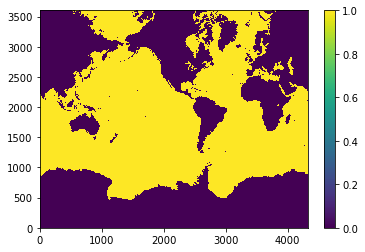

In [57]:
plt.pcolormesh(Umask[0,:,:])
plt.colorbar()

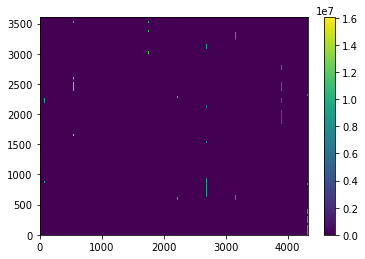

In [58]:
plt.pcolormesh(dyu[:,:])
plt.colorbar()

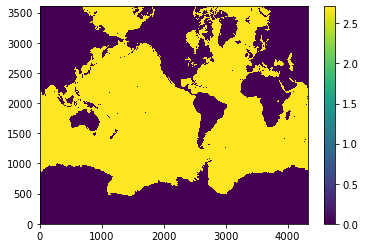

In [59]:
plt.pcolormesh(dzu[10,:,:])
plt.colorbar()